In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
# from lightgbm.sklearn import LGBMRegressor
# import lightgbm as lgb

In [ ]:
#기존 데이터 & 20년 4월데이터 불러오기
data_ = pd.read_csv('data_ver1/201901-202003.csv')
data_4 = pd.read_csv('data_ver1/202004.csv')

In [ ]:
data = pd.concat([data_,data_4])

In [ ]:
data

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1350317,202004,충북,충주시,휴양콘도 운영업,충북,충주시,20s,1,1,5,77000,5
1350318,202004,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,6,92000,6
1350319,202004,충북,충주시,휴양콘도 운영업,충북,충주시,40s,2,3,5,193000,5
1350320,202004,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,5,86000,7


In [ ]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

def grap_month_covid(data):
    data = str(data)
    return int(data[5:7])

def grap_date_covid(data):
    data = str(data)
    return int(data[8:10])

In [ ]:
#원본 데이터프레임 복사
bm = data.copy()

In [ ]:
bm

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3
...,...,...,...,...,...,...,...,...,...,...,...,...
1350317,202004,충북,충주시,휴양콘도 운영업,충북,충주시,20s,1,1,5,77000,5
1350318,202004,충북,충주시,휴양콘도 운영업,충북,충주시,30s,1,2,6,92000,6
1350319,202004,충북,충주시,휴양콘도 운영업,충북,충주시,40s,2,3,5,193000,5
1350320,202004,충북,충주시,휴양콘도 운영업,충북,충주시,50s,1,4,5,86000,7


In [ ]:
#날짜 전처리
bm['month'] = bm['REG_YYMM'].apply(lambda x: grap_month(x))
bm['year'] = bm['REG_YYMM'].apply(lambda x: grap_year(x))
bm = bm.drop(['REG_YYMM'],axis=1)

In [ ]:
#필요없는 피처 제거
bm = bm.drop(['CARD_CCG_NM', 'HOM_CCG_NM','SEX_CTGO_CD','CSTMR_CNT','CNT'], axis=1)

In [ ]:
#10대20대, 나머지 세대 구분
bm['AGE']= bm['AGE'].apply(lambda x: '1020s' if x =='10s'or x=='20s' else '3060s')

In [ ]:
#독신, 나머지 구분
bm['FLC']= bm['FLC'].apply(lambda x: 'single' if x ==1 else 'family')

In [ ]:
#남은 피처 기준으로 groupby후 사용금액 더하기
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM','AGE','year','FLC','month']
bm = bm.groupby(columns).sum().reset_index(drop=False)

In [ ]:
#관광지 구분(1,0 표시)
travel = ['제주','대구','전북','인천','부산','대전','광주','강원']
bm['out_home']= bm['CARD_SIDO_NM'].apply(lambda x: 1 if x in travel else 0)

In [ ]:
bm.to_csv('관광지 구분(home, out 분리전).csv', encoding='utf-8-sig')

In [ ]:
#카드 사용 지역과 거주지 동일여부로 데이터프레임 분리
home_condition = bm['CARD_SIDO_NM']==bm['HOM_SIDO_NM']
home = bm[home_condition]

In [ ]:
home.to_csv('지역별주민+관광지 구분(home).csv', encoding='utf-8-sig')

In [ ]:
out_condition = bm['CARD_SIDO_NM']!=bm['HOM_SIDO_NM']
out = bm[out_condition]

In [ ]:
out.to_csv('지역별주민+관광지 구분(out).csv', encoding='utf-8-sig')

# 각각 생성된 피처들 하나의 데이터프레임으로 합치기

In [ ]:
bm = pd.read_csv('./관광지 구분(home, out 분리전).csv')

In [ ]:
bm

,Unnamed: 0,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,year,FLC,month,AMT,out_home
0,0,강원,건강보조식품 소매업,강원,1020s,2019,family,2,216200,1
1,1,강원,건강보조식품 소매업,강원,1020s,2019,family,3,88500,1
2,2,강원,건강보조식품 소매업,강원,1020s,2019,family,4,250000,1
3,3,강원,건강보조식품 소매업,강원,1020s,2019,family,5,449000,1
4,4,강원,건강보조식품 소매업,강원,1020s,2019,family,6,270000,1
...,...,...,...,...,...,...,...,...,...,...
265430,265430,충북,휴양콘도 운영업,충북,3060s,2020,family,1,33598776,0
265431,265431,충북,휴양콘도 운영업,충북,3060s,2020,family,2,9217300,0
265432,265432,충북,휴양콘도 운영업,충북,3060s,2020,family,3,1724650,0
265433,265433,충북,휴양콘도 운영업,충북,3060s,2020,family,4,1701450,0


In [ ]:
#업종별 코로나 효과
bm_ci = pd.read_csv('data_ver1/업종별_코로나매출.csv')
bm_ci.fillna(0,inplace=True)
bm_ci['diff']=bm_ci['diff_home']+bm_ci['diff_out']
bm_ci.drop(['diff_home','diff_out'],axis=1,inplace=True)
bm_ci

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,year,FLC,month,AMT,out_home,diff
0,강원,건강보조식품 소매업,강원,1020s,2019,family,2,216200,1,-0.106782
1,강원,건강보조식품 소매업,강원,1020s,2019,family,3,88500,1,-0.106782
2,강원,건강보조식품 소매업,강원,1020s,2019,family,4,250000,1,-0.106782
3,강원,건강보조식품 소매업,강원,1020s,2019,family,5,449000,1,-0.106782
4,강원,건강보조식품 소매업,강원,1020s,2019,family,6,270000,1,-0.106782
...,...,...,...,...,...,...,...,...,...,...
265430,충남,정기 항공 운송업,제주,3060s,2019,family,6,2172000,0,-0.862732
265431,충남,정기 항공 운송업,제주,3060s,2019,family,7,707000,0,-0.862732
265432,충남,정기 항공 운송업,제주,3060s,2019,family,8,1481500,0,-0.862732
265433,충남,정기 항공 운송업,제주,3060s,2019,family,9,169000,0,-0.862732


In [ ]:
#코로나 검색량
search = pd.read_csv('data_ver1/원본+월별 코로나 검색량.csv')
search = search[['year','month','검색량(=100)']]
search = search.drop_duplicates()

In [ ]:
bm_ci_search = pd.merge(bm_ci,search,on=['year','month'])

In [ ]:
bm_ci_search

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,year,FLC,month,AMT,out_home,diff,검색량(=100)
0,강원,건강보조식품 소매업,강원,1020s,2019,family,2,216200,1,-0.106782,0.02146
1,강원,건강보조식품 소매업,강원,1020s,2019,single,2,1517000,1,-0.106782,0.02146
2,강원,건강보조식품 소매업,강원,3060s,2019,family,2,144433371,1,-0.106782,0.02146
3,경기,건강보조식품 소매업,경기,1020s,2019,family,2,5567900,0,-0.106782,0.02146
4,경기,건강보조식품 소매업,경기,1020s,2019,single,2,20210530,0,-0.106782,0.02146
...,...,...,...,...,...,...,...,...,...,...,...
265430,제주,정기 항공 운송업,충남,1020s,2020,single,4,431300,1,-0.862732,40.21097
265431,제주,정기 항공 운송업,충남,3060s,2020,family,4,6296000,1,-0.862732,40.21097
265432,제주,정기 항공 운송업,충남,3060s,2020,single,4,181300,1,-0.862732,40.21097
265433,제주,정기 항공 운송업,충북,1020s,2020,single,4,480500,1,-0.862732,40.21097


In [ ]:
#코로나 확진자수
covid = pd.read_csv('data_ver1/Covid19.csv')

In [ ]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

def grap_month_covid(data):
    data = str(data)
    return int(data[5:7])

def grap_date_covid(data):
    data = str(data)
    return int(data[8:10])

In [ ]:
covid = pd.read_csv('data_ver1/Covid19.csv')
covid = covid.drop(['time','released','deceased'],axis=1)
covid = covid[covid['date'].isin(['2020-01-31','2020-02-29','2020-03-31','2020-04-30'])]

covid['month'] = covid['date'].apply(lambda x: grap_month_covid(x))
covid['year'] = covid['date'].apply(lambda x: grap_year(x))
covid = covid.drop(['date'],axis=1)
covid = covid.sort_values(by=['province','year','month'])

be = ['Seoul', 'Busan', 'Daegu', 'Incheon', 'Gwangju', 'Daejeon',
       'Ulsan', 'Sejong', 'Gyeonggi-do', 'Gangwon-do',
       'Chungcheongbuk-do', 'Chungcheongnam-do', 'Jeollabuk-do',
       'Jeollanam-do', 'Gyeongsangbuk-do', 'Gyeongsangnam-do', 'Jeju-do']
af = ['서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종', '경기', '강원', '충북',
       '충남', '전북', '전남', '경북', '경남', '제주']

for i in range(len(covid['province'].unique())):
    covid['province'].replace(be[i],af[i], inplace=True)

In [ ]:
covid_eda = covid.copy()

for i in range(len(covid)-1):
    if covid.iloc[i+1,0]==covid.iloc[i,0]:
        covid_eda.iloc[i+1,1]=covid.iloc[i+1,1]-covid.iloc[i,1]
        
covid_eda.rename({'province':'CARD_SIDO_NM'},axis='columns',inplace=True)

In [ ]:
covid_eda

,CARD_SIDO_NM,confirmed,month,year
188,부산,0,1,2020
681,부산,80,2,2020
1208,부산,39,3,2020
1718,부산,18,4,2020
197,충북,0,1,2020
...,...,...,...,...
1717,서울,183,4,2020
193,울산,0,1,2020
686,울산,17,2,2020
1213,울산,22,3,2020


In [ ]:
bm_ci_search_covid = pd.merge(bm_ci_search,covid_eda,how='left',on=['year','month','CARD_SIDO_NM'])
bm_ci_search_covid.fillna(0,inplace=True)

In [ ]:
#소비심리
consume = pd.read_csv('data_ver1/카드사용액+소비심리.csv')
consume = consume[['year','month','HOM_SIDO_NM','소비자심리지수']]
consume = consume.drop_duplicates()
consume

,year,month,HOM_SIDO_NM,소비자심리지수
0,2019,2,강원,97
1,2019,3,강원,96
2,2019,4,강원,98
3,2019,5,강원,95
4,2019,6,강원,95
...,...,...,...,...
1925,2020,4,울산,70
2019,2019,4,전북,100
2062,2020,3,제주,70
2078,2020,4,제주,78


In [ ]:
bm_ci_search_covid_consume = pd.merge(bm_ci_search_covid,consume,on=['year','month','HOM_SIDO_NM'])
bm_ci_search_covid_consume

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,year,FLC,month,AMT,out_home,diff,검색량(=100),confirmed,소비자심리지수
0,강원,건강보조식품 소매업,강원,1020s,2019,family,2,216200,1,-0.106782,0.02146,0.0,97
1,강원,건강보조식품 소매업,강원,1020s,2019,single,2,1517000,1,-0.106782,0.02146,0.0,97
2,강원,건강보조식품 소매업,강원,3060s,2019,family,2,144433371,1,-0.106782,0.02146,0.0,97
3,강원,골프장 운영업,강원,1020s,2019,family,2,1629420,1,0.034461,0.02146,0.0,97
4,강원,골프장 운영업,강원,1020s,2019,single,2,8254950,1,0.034461,0.02146,0.0,97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265430,서울,정기 항공 운송업,충북,1020s,2020,single,4,3017380,0,-0.862732,40.21097,183.0,72
265431,서울,정기 항공 운송업,충북,3060s,2020,family,4,37190900,0,-0.862732,40.21097,183.0,72
265432,인천,정기 항공 운송업,충북,1020s,2020,single,4,54700,1,-0.862732,40.21097,29.0,72
265433,제주,정기 항공 운송업,충북,1020s,2020,single,4,480500,1,-0.862732,40.21097,4.0,72


In [ ]:
bm_ci_search_covid_consume.to_csv('train.csv', encoding='utf-8-sig')

# 모델 시작

In [ ]:
#피처 다합쳐진 데이터프레임 불러오기(드라이브 상에 TRAIN(소수점포함) 파일 불러오면 됨)
bm_ci_search_covid_consume = pd.read_csv('./train.csv')
bm_ci_search_covid_consume.drop(['Unnamed: 0'],axis=1,inplace=True)
bm_ci_search_covid_consume

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,year,FLC,month,AMT,out_home,diff,검색량(=100),confirmed,소비자심리지수
0,강원,건강보조식품 소매업,강원,1020s,2019,family,2,216200,1,-0.106782,0.02146,0.0,97.1
1,강원,건강보조식품 소매업,강원,1020s,2019,single,2,1517000,1,-0.106782,0.02146,0.0,97.1
2,강원,건강보조식품 소매업,강원,3060s,2019,family,2,144433371,1,-0.106782,0.02146,0.0,97.1
3,강원,골프장 운영업,강원,1020s,2019,family,2,1629420,1,0.034461,0.02146,0.0,97.1
4,강원,골프장 운영업,강원,1020s,2019,single,2,8254950,1,0.034461,0.02146,0.0,97.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
265430,서울,정기 항공 운송업,충북,1020s,2020,single,4,3017380,0,-0.862732,40.21097,183.0,72.4
265431,서울,정기 항공 운송업,충북,3060s,2020,family,4,37190900,0,-0.862732,40.21097,183.0,72.4
265432,인천,정기 항공 운송업,충북,1020s,2020,single,4,54700,1,-0.862732,40.21097,29.0,72.4
265433,제주,정기 항공 운송업,충북,1020s,2020,single,4,480500,1,-0.862732,40.21097,4.0,72.4


In [ ]:
#home 분리(거주지, 사용지역 같은 데이터)
home_condition = bm_ci_search_covid_consume['CARD_SIDO_NM']==bm_ci_search_covid_consume['HOM_SIDO_NM']
home = bm_ci_search_covid_consume[home_condition]
home.to_csv('train_home.csv', encoding='utf-8-sig')

In [ ]:
#out 분리(거주지, 사용지역 다른 데이터)
out_condition = bm_ci_search_covid_consume['CARD_SIDO_NM']!=bm_ci_search_covid_consume['HOM_SIDO_NM']
out = bm_ci_search_covid_consume[out_condition]
out.to_csv('train_out.csv', encoding='utf-8-sig')

# 19년 234월 20년 234월 차이값 계산

In [ ]:
#2019년 234월 데이터 뽑아내기
year2019 = home['year']==2019
month2 = home['month']==2
month3 = home['month']==3
month4 = home['month']==4

year2019_ = out['year']==2019
month2_ = out['month']==2
month3_ = out['month']==3
month4_ = out['month']==4

home_2019 = home[year2019&(month2|month3|month4)]
out_2019 = out[year2019_&(month2_|month3_|month4_)]

In [ ]:
#2020년 234월 데이터 뽑아내기
year2020 = home['year']==2020
month2 = home['month']==2
month3 = home['month']==3
month4 = home['month']==4

year2020_ = out['year']==2020
month2_ = out['month']==2
month3_ = out['month']==3
month4_ = out['month']==4

home_2020 = home[year2020&(month2|month3|month4)]
out_2020 = out[year2020_&(month2_|month3_|month4_)]

In [ ]:
#기존 데이터의 피처가 같은 것끼리 매칭시키기 위해 merge
home_merge = pd.merge(home_2019,home_2020,on=['CARD_SIDO_NM','STD_CLSS_NM','HOM_SIDO_NM','AGE','FLC','month'])
out_merge = pd.merge(out_2019,out_2020,on=['CARD_SIDO_NM','STD_CLSS_NM','HOM_SIDO_NM','AGE','FLC','month'])

In [ ]:
home_merge = home_merge.drop(['year_x','year_y','out_home_x','diff_x','검색량(=100)_x','confirmed_x','소비자심리지수_x'],axis=1)
out_merge = out_merge.drop(['year_x','year_y','out_home_x','diff_x','검색량(=100)_x','confirmed_x','소비자심리지수_x'],axis=1)

#2019년 2020년 AMT 차이값 계산
home_merge['AMT_DIFF'] = (home_merge['AMT_x']-home_merge['AMT_y'])
out_merge['AMT_DIFF'] = (out_merge['AMT_x']-out_merge['AMT_y'])
# home_merge['AMT_DIFF'] = home_merge['AMT_DIFF'].map(log)
# out_merge['AMT_DIFF'] = out_merge['AMT_DIFF'].map(log)

home_merge = home_merge.drop(['AMT_x','AMT_y'],axis=1)
out_merge = out_merge.drop(['AMT_x','AMT_y'],axis=1)

In [ ]:
#이상치 범위 조정
home_merge = home_merge[home_merge['AMT_DIFF']<10000000]
home_merge = home_merge[-10000000<home_merge['AMT_DIFF']]
out_merge = out_merge[out_merge['AMT_DIFF']<1000000]
out_merge = out_merge[-1000000<out_merge['AMT_DIFF']]

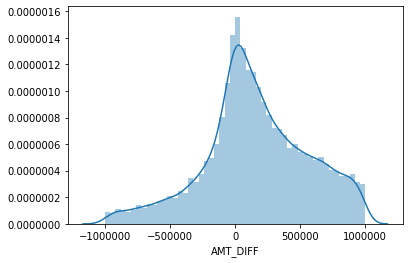

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#타겟값 형태파악
sns.distplot(out_merge['AMT_DIFF'])

# 모델 성능확인

In [ ]:
#AMT차이가 양수이면 그냥 로그씌우고 음수이면 -없애고 로그 씌우고 -붙이는 함수
#성능이 너무안좋아서 우선 음수인경우 0으로
# def log(amt_diff):
#     if amt_diff >= 0:
#         amt_diff = np.log1p(amt_diff)
#     else:
#         amt_diff = -np.log1p(-amt_diff)
#     return amt_diff

In [ ]:
#target값 로그변환

# home_merge['AMT_DIFF'] = home_merge['AMT_DIFF'].map(log)
# out_merge['AMT_DIFF'] = out_merge['AMT_DIFF'].map(log)

#명목형 변수 원핫인코딩
home_dummy = pd.get_dummies(home_merge,columns=['CARD_SIDO_NM','STD_CLSS_NM','HOM_SIDO_NM','AGE','FLC','month'])
out_dummy = pd.get_dummies(out_merge,columns=['CARD_SIDO_NM','STD_CLSS_NM','HOM_SIDO_NM','AGE','FLC','month'])

In [ ]:
out_dummy

,out_home_y,diff_y,검색량(=100)_y,confirmed_y,소비자심리지수_y,AMT_DIFF,CARD_SIDO_NM_강원,CARD_SIDO_NM_경기,CARD_SIDO_NM_경남,CARD_SIDO_NM_경북,...,HOM_SIDO_NM_제주,HOM_SIDO_NM_충남,HOM_SIDO_NM_충북,AGE_1020s,AGE_3060s,FLC_family,FLC_single,month_2,month_3,month_4
2,0,-0.393612,84.25142,10.0,97.2,-458000,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
3,0,0.022604,84.25142,77.0,97.2,136250,0,1,0,0,...,0,0,0,0,1,1,0,1,0,0
5,0,-0.219717,84.25142,77.0,97.2,-196370,0,1,0,0,...,0,0,0,1,0,0,1,1,0,0
6,0,-0.219717,84.25142,77.0,97.2,59580,0,1,0,0,...,0,0,0,0,1,1,0,1,0,0
7,0,-0.219717,84.25142,488.0,97.2,-475800,0,0,0,1,...,0,0,0,0,1,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33365,0,-0.199789,40.21097,65.0,72.4,-264810,0,0,0,1,...,0,0,1,0,1,1,0,0,0,1
33366,1,-0.199789,40.21097,4.0,72.4,2790,0,0,0,0,...,0,0,1,1,0,1,0,0,0,1
33372,0,-0.199789,40.21097,0.0,72.4,176810,0,0,0,0,...,0,0,1,1,0,0,1,0,0,1
33374,0,-0.199789,40.21097,15.0,72.4,935350,0,0,0,0,...,0,0,1,1,0,0,1,0,0,1


In [ ]:
#RMSLE함수 정의
def get_rmsle_home(model): 
    pred = model.predict(Xhome_test)
    squared_error = (np.log((yhome_test+1)/(pred+1)))** 2
    rmsle = np.sqrt(np.mean(squared_error))
    print(rmsle)
    return rmsle

def get_rmsle_out(model): 
    pred = model.predict(Xout_test)
    squared_error = (np.log((yout_test+1)/(pred+1)))** 2
    rmsle = np.sqrt(np.mean(squared_error))
    print(rmsle)
    return rmsle

# def get_rmsles(models):
#     rmsles = [ ]
#     for model in models:
#         rmsle = get_rmsle(model)
#         rmsles.append(rmsle)
#     return rmsles

In [ ]:
from sklearn import preprocessing

#인풋데이터(피처) 생성
home_features = home_dummy.drop('AMT_DIFF',axis=1, inplace=False)
out_features = out_dummy.drop('AMT_DIFF',axis=1, inplace=False)

#인풋데이터에 정규화 적용
min_max_scaler = preprocessing.MinMaxScaler()
home_scaled = min_max_scaler.fit_transform(home_features)
out_scaled = min_max_scaler.fit_transform(out_features)

home_features = pd.DataFrame(home_scaled)
out_features = pd.DataFrame(out_scaled)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#타겟값 생성
home_target = home_dummy['AMT_DIFF']
out_target = out_dummy['AMT_DIFF']

#학습,테스트 데이터 분리
Xhome_train, Xhome_test, yhome_train, yhome_test = train_test_split(home_features, home_target, test_size=0.2, random_state=0)
Xout_train, Xout_test, yout_train, yout_test = train_test_split(out_features, out_target, test_size=0.2, random_state=0)

In [ ]:
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso


#SVR 
svr_home = SVR()
svr_out = SVR()
svr_home.fit(Xhome_train, yhome_train)
svr_out.fit(Xout_train, yout_train)

#LinearRegression
lr_home = LinearRegression()
lr_out = LinearRegression()
lr_home.fit(Xhome_train, yhome_train)
lr_out.fit(Xout_train, yout_train)

# #Ridge 
ridge_home = Ridge()
ridge_out = Ridge()
ridge_home.fit(Xhome_train, yhome_train)
ridge_out.fit(Xout_train, yout_train)

#Lasso
lasso_home = Lasso()
lasso_out = Lasso()
lasso_home.fit(Xhome_train, yhome_train)
lasso_out.fit(Xout_train, yout_train)

#회귀트리관련 모델도 추가해야됨

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
#차이값에 대한 rmsle결과 확인
get_rmsle_out(svr_home)
get_rmsle_home(svr_out)

get_rmsle_out(lr_home)
get_rmsle_home(lr_out)

get_rmsle_out(ridge_home)
get_rmsle_home(ridge_out)

get_rmsle_out(lasso_home)
get_rmsle_home(lasso_out)

1.3134051003866853
2.877461576691856
31.573920983801596
17.798854124237707
2.6621036000561284
3.096894700515385
2.699877680803126
3.0263692926216756


3.0263692926216756